# SFTDatasetPacked 测试

本 notebook 用于测试 `SFTDatasetPacked` 类的功能，包括：
- 数据打包功能
- Attention mask 生成
- 2D Attention Mask 矩阵可视化
- 打包效率统计

## 0. 准备测试数据（随机采样 1%）

In [1]:
# 清楚缓存
import shutil
shutil.rmtree('../.cache/sft_packed', ignore_errors=True)

In [2]:
import json
import random
from pathlib import Path
from datasets import load_dataset

# 设置随机种子以确保可重复性
random.seed(42)

# 输入和输出文件路径
input_file = "../dataset/sft.jsonl"
# output_file = Path("../dataset/sft_sample_01pct.jsonl")
# sample_ratio = 0.01  # 1%

# # 使用与 SFTDataset 相同的 cache_dir
from data_loader.sft_dataset import SFT_CACHE_DIR
cache_dir = SFT_CACHE_DIR

# print(f"从 {input_file} 中随机采样 {sample_ratio*100:.1f}% 的数据...")
# print(f"使用 cache_dir: {cache_dir}")

# # 使用 load_dataset 加载数据（会使用缓存，速度更快）
# print("加载数据集（使用缓存）...")
# dataset = load_dataset('json', data_files=input_file, split='train', cache_dir=cache_dir)

# total_samples = len(dataset)
# sample_size = max(1, int(total_samples * sample_ratio))

# print(f"总样本数: {total_samples:,}")
# print(f"采样数量: {sample_size:,}")

# # 随机采样索引
# sampled_indices = random.sample(range(total_samples), sample_size)
# sampled_indices.sort()  # 排序以便后续处理

# # 写入采样后的数据
# print("保存采样后的数据...")
# with open(output_file, 'w', encoding='utf-8') as f:
#     for idx in sampled_indices:
#         sample = dataset[idx]
#         f.write(json.dumps(sample, ensure_ascii=False) + '\n')

# print(f"✓ 采样完成！已保存到: {output_file}")
# print(f"  实际采样率: {sample_size/total_samples*100:.2f}%")

# # 设置后续使用的数据文件路径
test_data_path = str(input_file)

/root/vermind/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 导入和设置

In [3]:
import sys
import os
import importlib
sys.path.insert(0, os.path.abspath('..'))

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# 重新加载模块以确保使用最新代码
import data_loader.sft_dataset
importlib.reload(data_loader.sft_dataset)
from data_loader import SFTDataset, SFTDatasetPacked

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 2. 加载 Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained("../vermind_tokenizer")
print(f"Tokenizer vocab size: {len(tokenizer)}")
print(f"Pad token: {tokenizer.pad_token} (id: {tokenizer.pad_token_id})")
print(f"BOS token: {tokenizer.bos_token} (id: {tokenizer.bos_token_id})")
print(f"EOS token: {tokenizer.eos_token} (id: {tokenizer.eos_token_id})")

Tokenizer vocab size: 6400
Pad token: <|endoftext|> (id: 0)
BOS token: <|im_start|> (id: 1)
EOS token: <|im_end|> (id: 2)


## 3. 创建数据集（普通 vs 打包）

In [5]:
# 创建普通数据集（使用采样后的数据）
normal_dataset = SFTDataset(
    jsonl_path=test_data_path,
    tokenizer=tokenizer,
    max_length=2048
)
print(f"普通数据集大小: {len(normal_dataset)}")

Generating train split: 68003 examples [00:00, 103153.07 examples/s]


普通数据集大小: 68003


In [ ]:
# 然后重新创建数据集
packed_dataset = SFTDatasetPacked(
    jsonl_path=test_data_path,
    tokenizer=tokenizer,
    max_length=2048,
    use_cache=True
)

[SFTDatasetPacked] 缓存文件不存在: 78149282f6264396.pkl，将重新打包
[SFTDatasetPacked] 开始打包...
[SFTDatasetPacked] 样本数: 16387416, batch_size: 128, 批次数量: 128027


Processing:   1%|          | 1346/128027 [01:35<2:32:23, 13.86it/s]

## 4. 可视化 2D Attention Mask 矩阵

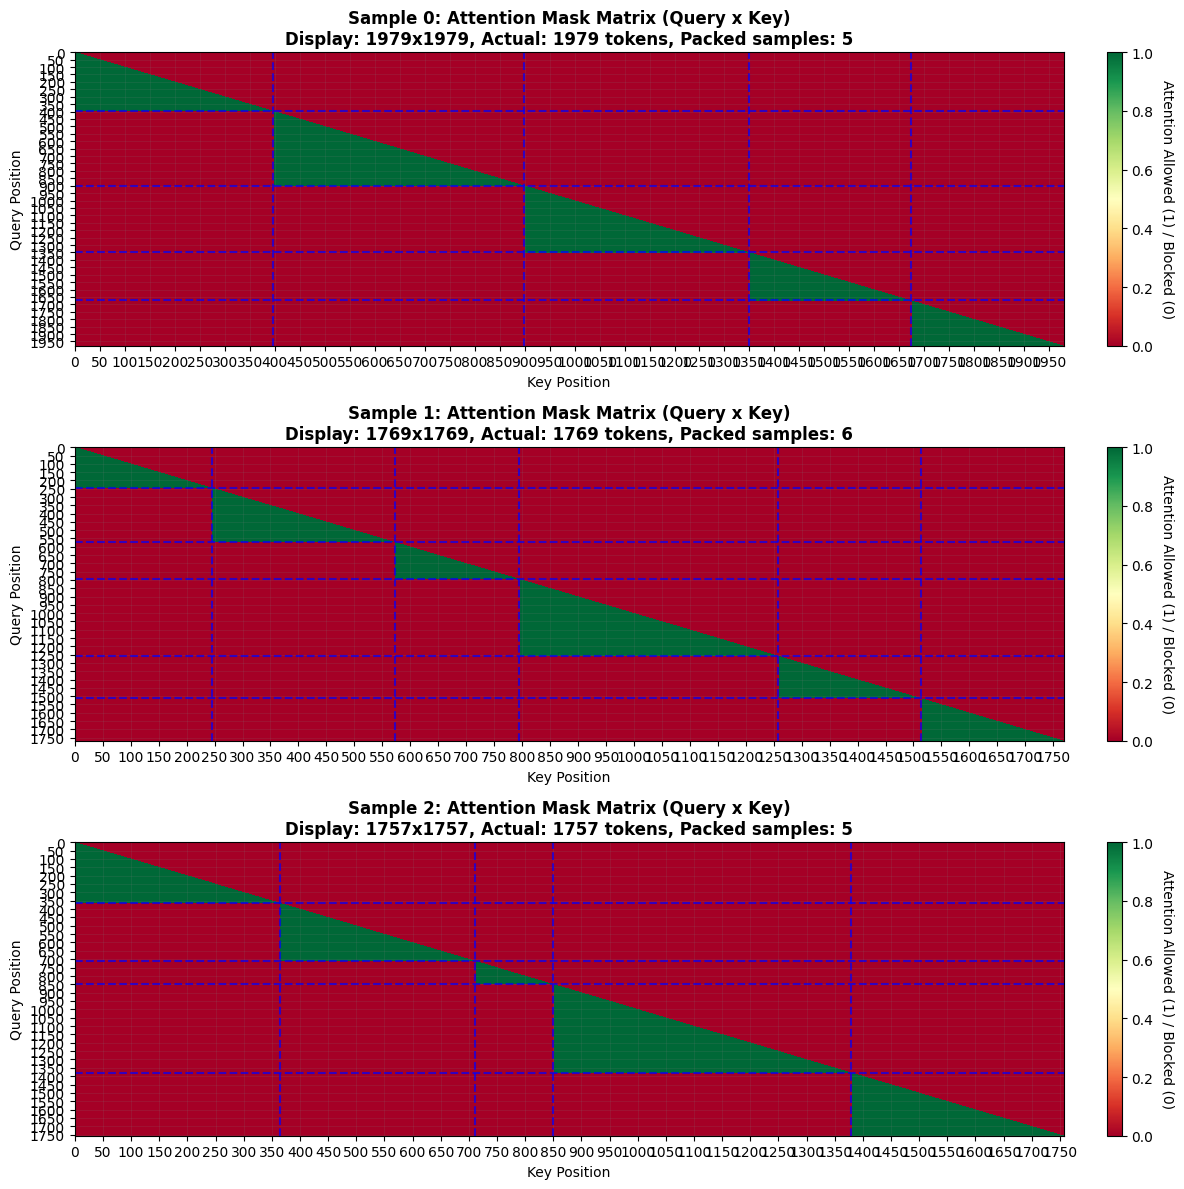


=== 2D Attention Mask 矩阵详细信息 ===

样本 0:
  显示大小: 1979x1979
  实际长度: 1979
  打包样本数: 5
  样本边界位置: [0, 397, 899, 1350, 1673, 1979]
  允许 attention 的位置数: 406479
  总位置数: 3916441
  Attention 密度: 10.38%

样本 1:
  显示大小: 1769x1769
  实际长度: 1769
  打包样本数: 6
  样本边界位置: [0, 245, 572, 795, 1258, 1513, 1769]
  允许 attention 的位置数: 281691
  总位置数: 3129361
  Attention 密度: 9.00%

样本 2:
  显示大小: 1757x1757
  实际长度: 1757
  打包样本数: 5
  样本边界位置: [0, 364, 711, 850, 1379, 1757]
  允许 attention 的位置数: 348354
  总位置数: 3087049
  Attention 密度: 11.28%


In [7]:
def create_attention_mask_matrix(packed_dataset, sample_idx, tokenizer, max_display=500):
    """从打包数据集中获取预生成的 2D attention mask"""
    # 获取打包后的数据（现在包含预生成的 2D attention mask）
    input_ids, labels, attention_mask_2d, boundaries, position_ids = packed_dataset[sample_idx]
    
    # 转换为 numpy
    if isinstance(attention_mask_2d, torch.Tensor):
        mask_matrix = attention_mask_2d.numpy().astype(np.float32)
    else:
        mask_matrix = np.array(attention_mask_2d, dtype=np.float32)
    
    # 计算实际长度（非 padding 的 token 数）
    if isinstance(input_ids, torch.Tensor):
        is_padding = (input_ids == tokenizer.pad_token_id).numpy()
    else:
        is_padding = np.array(input_ids) == tokenizer.pad_token_id
    actual_length = int((~is_padding).sum())
    
    # 限制显示长度
    display_length = min(max_display, mask_matrix.shape[0] if len(mask_matrix.shape) > 1 else len(mask_matrix), actual_length)
    
    # 截取要显示的部分
    mask_matrix_display = mask_matrix[:display_length, :display_length]
    
    return mask_matrix_display, boundaries, display_length, actual_length

# 可视化 2-3 个样本的 attention mask 矩阵
num_samples_to_show = min(3, len(packed_dataset))
fig, axes = plt.subplots(num_samples_to_show, 1, figsize=(12, 4 * num_samples_to_show))

if num_samples_to_show == 1:
    axes = [axes]

for idx in range(num_samples_to_show):
    # 创建 attention mask 矩阵
    mask_matrix, boundaries, display_length, actual_length = create_attention_mask_matrix(
        packed_dataset, idx, tokenizer, max_display=2048
    )
    
    # 绘制热力图
    im = axes[idx].imshow(mask_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1, 
                         interpolation='nearest')
    axes[idx].set_title(f'Sample {idx}: Attention Mask Matrix (Query x Key)\n'
                       f'Display: {display_length}x{display_length}, Actual: {actual_length} tokens, '
                       f'Packed samples: {len(boundaries)-1}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Key Position')
    axes[idx].set_ylabel('Query Position')
    
    # 标记打包样本边界（蓝色虚线）
    for boundary in boundaries[1:-1]:  # 跳过第一个和最后一个
        if boundary < display_length:
            axes[idx].axhline(y=boundary, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
            axes[idx].axvline(x=boundary, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    cbar.set_label('Attention Allowed (1) / Blocked (0)', rotation=270, labelpad=15)
    
    # 添加网格线（每50个token）
    axes[idx].set_xticks(np.arange(0, display_length, 50))
    axes[idx].set_yticks(np.arange(0, display_length, 50))
    axes[idx].grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig("./assets/attention_mask_matrix_2d.jpg", dpi=150, bbox_inches='tight')
plt.show()

# 打印详细信息
print("\n=== 2D Attention Mask 矩阵详细信息 ===")
for idx in range(num_samples_to_show):
    mask_matrix, boundaries, display_length, actual_length = create_attention_mask_matrix(
        packed_dataset, idx, tokenizer, max_display=2048
    )
    
    print(f"\n样本 {idx}:")
    print(f"  显示大小: {display_length}x{display_length}")
    print(f"  实际长度: {actual_length}")
    print(f"  打包样本数: {len(boundaries)-1}")
    print(f"  样本边界位置: {boundaries}")
    print(f"  允许 attention 的位置数: {int(mask_matrix.sum())}")
    print(f"  总位置数: {display_length * display_length}")
    print(f"  Attention 密度: {(mask_matrix.sum() / (display_length * display_length) * 100):.2f}%")

## 5. 基本功能测试

In [8]:
# 测试获取数据
print("=== 普通数据集 ===")
normal_input_ids, normal_labels = normal_dataset[0]
print(f"Input IDs shape: {normal_input_ids.shape}")
print(f"Labels shape: {normal_labels.shape}")
print(f"Padding tokens 数量: {(normal_input_ids == tokenizer.pad_token_id).sum().item()}")

print("\n=== 打包数据集 ===")
packed_input_ids, packed_labels, packed_attention_mask, boundaries, position_ids = packed_dataset[0]
print(f"Input IDs shape: {packed_input_ids.shape}")
print(f"Labels shape: {packed_labels.shape}")
print(f"Attention Mask shape: {packed_attention_mask.shape}")
print(f"实际 token 数量: {(packed_input_ids != tokenizer.pad_token_id).sum().item()}")
print(f"Padding tokens 数量: {(packed_input_ids == tokenizer.pad_token_id).sum().item()}")
print(f"Boundaries: {boundaries}")
print(f"打包的样本数: {len(boundaries) - 1}")

=== 普通数据集 ===
Input IDs shape: torch.Size([2048])
Labels shape: torch.Size([2048])
Padding tokens 数量: 1651

=== 打包数据集 ===
Input IDs shape: torch.Size([2048])
Labels shape: torch.Size([2048])
Attention Mask shape: torch.Size([2048, 2048])
实际 token 数量: 1979
Padding tokens 数量: 69
Boundaries: [0, 397, 899, 1350, 1673, 1979]
打包的样本数: 5


## 6. 打包效率统计

In [9]:
# 计算打包效率
total_tokens_normal = 0
total_padding_normal = 0

for i in range(min(100, len(normal_dataset))):  # 只检查前100个样本
    input_ids, _ = normal_dataset[i]
    total_tokens_normal += len(input_ids)
    total_padding_normal += (input_ids == tokenizer.pad_token_id).sum().item()

total_tokens_packed = 0
total_padding_packed = 0

for i in range(len(packed_dataset)):
    input_ids, _, attention_mask, _, _ = packed_dataset[i]
    total_tokens_packed += len(input_ids)
    total_padding_packed += (input_ids == tokenizer.pad_token_id).sum().item()

print("=== 效率对比 ===")
print(f"普通数据集（前100个样本）:")
print(f"  总 tokens: {total_tokens_normal}")
print(f"  Padding tokens: {total_padding_normal}")
print(f"  有效利用率: {(1 - total_padding_normal / total_tokens_normal) * 100:.2f}%")

print(f"\n打包数据集（全部样本）:")
print(f"  总 tokens: {total_tokens_packed}")
print(f"  Padding tokens: {total_padding_packed}")
print(f"  有效利用率: {(1 - total_padding_packed / total_tokens_packed) * 100:.2f}%")

print(f"\n压缩比: {len(normal_dataset) / len(packed_dataset):.2f}x")
print(f"样本数量: {len(normal_dataset)} -> {len(packed_dataset)}")

=== 效率对比 ===
普通数据集（前100个样本）:
  总 tokens: 204800
  Padding tokens: 173178
  有效利用率: 15.44%

打包数据集（全部样本）:
  总 tokens: 23521280
  Padding tokens: 2971388
  有效利用率: 87.37%

压缩比: 5.92x
样本数量: 68003 -> 11485


## 7. 测试 DataLoader 兼容性

In [10]:
from torch.utils.data import DataLoader
from data_loader import collate_fn_packed

# 测试 DataLoader 是否能正确处理打包数据集
loader = DataLoader(packed_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn_packed)

for batch_idx, batch in enumerate(loader):
    if len(batch) == 5:
        input_ids, labels, attention_mask, boundaries, position_ids = batch
        print(f"Batch {batch_idx}:")
        print(f"  Input IDs shape: {input_ids.shape}")
        print(f"  Labels shape: {labels.shape}")
        print(f"  Attention Mask shape: {attention_mask.shape}")
        print(f"  Position IDs shape: {position_ids.shape}")
        print(f"  Boundaries (list of {len(boundaries)} samples): {[len(b) for b in boundaries]}")
        print(f"  Boundaries (first sample): {boundaries[0]}")
    else:
        print(f"Batch {batch_idx}: Unexpected format - {len(batch)} items")
        print(f"  Batch contents: {[type(x).__name__ for x in batch]}")
    
    if batch_idx >= 2:  # 只显示前3个batch
        break

print("\n✓ DataLoader 兼容性测试通过！")


Batch 0:
  Input IDs shape: torch.Size([2, 2048])
  Labels shape: torch.Size([2, 2048])
  Attention Mask shape: torch.Size([2, 2048, 2048])
  Position IDs shape: torch.Size([2, 2048])
  Boundaries (list of 2 samples): [6, 7]
  Boundaries (first sample): [0, 397, 899, 1350, 1673, 1979]
Batch 1:
  Input IDs shape: torch.Size([2, 2048])
  Labels shape: torch.Size([2, 2048])
  Attention Mask shape: torch.Size([2, 2048, 2048])
  Position IDs shape: torch.Size([2, 2048])
  Boundaries (list of 2 samples): [6, 8]
  Boundaries (first sample): [0, 364, 711, 850, 1379, 1757]
Batch 2:
  Input IDs shape: torch.Size([2, 2048])
  Labels shape: torch.Size([2, 2048])
  Attention Mask shape: torch.Size([2, 2048, 2048])
  Position IDs shape: torch.Size([2, 2048])
  Boundaries (list of 2 samples): [7, 8]
  Boundaries (first sample): [0, 279, 574, 909, 1286, 1621, 1971]

✓ DataLoader 兼容性测试通过！


## 8. 详细检查打包错误

In [11]:
# 详细检查打包数据集的错误
print("=" * 80)
print("详细检查打包数据集")
print("=" * 80)

# 1. 检查数据集大小
print(f"\n1. 数据集大小检查:")
print(f"   原始样本数: {len(normal_dataset)}")
print(f"   打包后序列数: {len(packed_dataset)}")
print(f"   压缩比: {len(normal_dataset) / len(packed_dataset):.2f}x")

# 2. 检查每个打包序列的详细信息
# 注意：attention_mask 为 2D，实际 token 数用 input_ids 中非 padding 的数量
print(f"\n2. 检查前5个打包序列的详细信息:")
total_original_samples = 0
for i in range(min(5, len(packed_dataset))):
    input_ids, labels, attention_mask, boundaries, _ = packed_dataset[i]
    n_valid = (input_ids != tokenizer.pad_token_id).sum().item()
    n_pad = (input_ids == tokenizer.pad_token_id).sum().item()
    num_samples_in_pack = len(boundaries) - 1
    
    print(f"\n   序列 {i}:")
    print(f"     总长度: {len(input_ids)}")
    print(f"     实际 token 数: {n_valid}")
    print(f"     Padding token 数: {n_pad}")
    print(f"     打包的原始样本数: {num_samples_in_pack}")
    print(f"     边界位置: {boundaries}")
    print(f"     利用率: {n_valid / len(input_ids) * 100:.2f}%")
    
    total_original_samples += num_samples_in_pack

print(f"\n   前5个序列共包含 {total_original_samples} 个原始样本")

# 3. 验证 labels 的正确性（packed 中 -100 包含 padding + prompt，只检查 padding 处必为 -100）
print(f"\n3. 验证 labels 的正确性（检查前3个序列）:")
for i in range(min(3, len(packed_dataset))):
    input_ids, labels, attention_mask, boundaries, _ = packed_dataset[i]
    input_ids = input_ids.numpy()
    labels = labels.numpy()
    
    padding_mask = (input_ids == tokenizer.pad_token_id)
    label_ignore_mask = (labels == -100)
    # 错误：padding 位置必须是 -100
    bad = (padding_mask & ~label_ignore_mask).sum()
    
    print(f"\n   序列 {i}:")
    print(f"     Labels 中 -100 的数量: {(labels == -100).sum()}")
    print(f"     Padding token 数量: {padding_mask.sum()}")
    print(f"     Padding 但非 -100 的数量（应为 0）: {bad}")
    
    if bad > 0:
        print(f"     ⚠️  警告: 存在 padding 位置 label 不为 -100！")
    else:
        print(f"     ✓ 所有 padding 位置均为 -100")

# 4. 检查边界信息
print(f"\n4. 检查边界信息（检查前3个序列）:")
for i in range(min(3, len(packed_dataset))):
    input_ids, labels, attention_mask, boundaries, _ = packed_dataset[i]
    n_valid = (input_ids != tokenizer.pad_token_id).sum().item()
    
    print(f"\n   序列 {i}:")
    print(f"     边界位置: {boundaries}")
    print(f"     有效 token 数: {n_valid}")
    print(f"     最后一个边界: {boundaries[-1]}")
    
    if boundaries[-1] > len(input_ids):
        print(f"     ⚠️  警告: 最后一个边界 {boundaries[-1]} 超出序列长度 {len(input_ids)}")
    else:
        print(f"     ✓ 边界在有效范围内")

# 5. 统计总体信息
print(f"\n5. 总体统计:")
total_packed_sequences = len(packed_dataset)
total_original_samples = len(normal_dataset)
total_tokens_packed = 0
total_padding_packed = 0
total_effective_tokens = 0

for i in range(len(packed_dataset)):
    input_ids, _, _, _, _ = packed_dataset[i]
    total_tokens_packed += len(input_ids)
    total_padding_packed += (input_ids == tokenizer.pad_token_id).sum().item()
    total_effective_tokens += (input_ids != tokenizer.pad_token_id).sum().item()

print(f"   打包序列总数: {total_packed_sequences}")
print(f"   原始样本总数: {total_original_samples}")
print(f"   总 token 数: {total_tokens_packed:,}")
print(f"   总 padding token 数: {total_padding_packed:,}")
print(f"   总有效 token 数: {total_effective_tokens:,}")
print(f"   平均利用率: {(1 - total_padding_packed / total_tokens_packed) * 100:.2f}%")
print(f"   平均每个序列包含的原始样本数: {total_original_samples / total_packed_sequences:.2f}")

print("\n" + "=" * 80)
print("检查完成！")
print("=" * 80)


详细检查打包数据集

1. 数据集大小检查:
   原始样本数: 68003
   打包后序列数: 11485
   压缩比: 5.92x

2. 检查前5个打包序列的详细信息:

   序列 0:
     总长度: 2048
     实际 token 数: 1979
     Padding token 数: 69
     打包的原始样本数: 5
     边界位置: [0, 397, 899, 1350, 1673, 1979]
     利用率: 96.63%

   序列 1:
     总长度: 2048
     实际 token 数: 1769
     Padding token 数: 279
     打包的原始样本数: 6
     边界位置: [0, 245, 572, 795, 1258, 1513, 1769]
     利用率: 86.38%

   序列 2:
     总长度: 2048
     实际 token 数: 1757
     Padding token 数: 291
     打包的原始样本数: 5
     边界位置: [0, 364, 711, 850, 1379, 1757]
     利用率: 85.79%

   序列 3:
     总长度: 2048
     实际 token 数: 2007
     Padding token 数: 41
     打包的原始样本数: 7
     边界位置: [0, 321, 497, 905, 1203, 1544, 1706, 2007]
     利用率: 98.00%

   序列 4:
     总长度: 2048
     实际 token 数: 1971
     Padding token 数: 77
     打包的原始样本数: 6
     边界位置: [0, 279, 574, 909, 1286, 1621, 1971]
     利用率: 96.24%

   前5个序列共包含 29 个原始样本

3. 验证 labels 的正确性（检查前3个序列）:



   序列 0:
     Labels 中 -100 的数量: 550
     Padding token 数量: 69
     Padding 但非 -100 的数量（应为 0）: 0
     ✓ 所有 padding 位置均为 -100

   序列 1:
     Labels 中 -100 的数量: 723
     Padding token 数量: 279
     Padding 但非 -100 的数量（应为 0）: 0
     ✓ 所有 padding 位置均为 -100

   序列 2:
     Labels 中 -100 的数量: 920
     Padding token 数量: 291
     Padding 但非 -100 的数量（应为 0）: 0
     ✓ 所有 padding 位置均为 -100

4. 检查边界信息（检查前3个序列）:

   序列 0:
     边界位置: [0, 397, 899, 1350, 1673, 1979]
     有效 token 数: 1979
     最后一个边界: 1979
     ✓ 边界在有效范围内

   序列 1:
     边界位置: [0, 245, 572, 795, 1258, 1513, 1769]
     有效 token 数: 1769
     最后一个边界: 1769
     ✓ 边界在有效范围内

   序列 2:
     边界位置: [0, 364, 711, 850, 1379, 1757]
     有效 token 数: 1757
     最后一个边界: 1757
     ✓ 边界在有效范围内

5. 总体统计:
   打包序列总数: 11485
   原始样本总数: 68003
   总 token 数: 23,521,280
   总 padding token 数: 2,971,388
   总有效 token 数: 20,549,892
   平均利用率: 87.37%
   平均每个序列包含的原始样本数: 5.92

检查完成！
